# 전이학습
## Pretrained Network : VGG16 (연습용 Network)
## VGG16
### CNN model, 16개의 convolution layer

In [1]:
from tensorflow.keras.applications import VGG16

# 특성 추출을 위해 기학습된 네트워크 이용
model_base = VGG16(weights='imagenet', # 이미지넷으로 학습한 weights
                   include_top=False, # 분류기 제외
                   input_shape=(150, 150, 3))

model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### 기학습된 network를 이용하여 특성 추출후 분류기(model)에 밀어넣어 학습

In [2]:
# 기학습된 network를 이용하여 특성 추출

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)
batch_size=20

def extract_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count,))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0

    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch
        
        i += 1
        if i * batch_size >= sample_count:
            break;
    
    return features, labels

train_features, train_labels = extract_feature(train_dir,2000)
validation_features, validation_labels = extract_feature(validation_dir,1000)
test_features, test_labels = extract_feature(test_dir,1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step


In [3]:
train_features = np.reshape(train_features, (2000,4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000,4 * 4 * 512))
test_features = np.reshape(test_features, (1000,4 * 4 * 512))

In [4]:
# 모델 생성 및 붙이기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(256,
                activation='relu',
                input_shape=(4*4*512,)))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# 모델 설정
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_result = model.fit(train_features,
                        train_labels,
                        epochs=30,
                        batch_size=20,
                        validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 7ms/step - loss: 0.4311 - accuracy: 0.7995 - val_loss: 0.2963 - val_accuracy: 0.8810
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2818 - accuracy: 0.8840 - val_loss: 0.2607 - val_accuracy: 0.8960
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2259 - accuracy: 0.9060 - val_loss: 0.2459 - val_accuracy: 0.9030
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1824 - accuracy: 0.9320 - val_loss: 0.2368 - val_accuracy: 0.9090
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1594 - accuracy: 0.9450 - val_loss: 0.2364 - val_accuracy: 0.9080
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1351 - accuracy: 0.9510 - val_loss: 0.2410 - val_accuracy: 0.9030
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1215 - accuracy: 0.9590 - val_loss: 0.2337 - val_accuracy: 0.9060
Epoch 

In [5]:
 model.evaluate(test_features, test_labels)

32/32 [==============================] - 0s 3ms/step - loss: 0.3548 - accuracy: 0.8810


[0.35484710335731506, 0.8809999823570251]

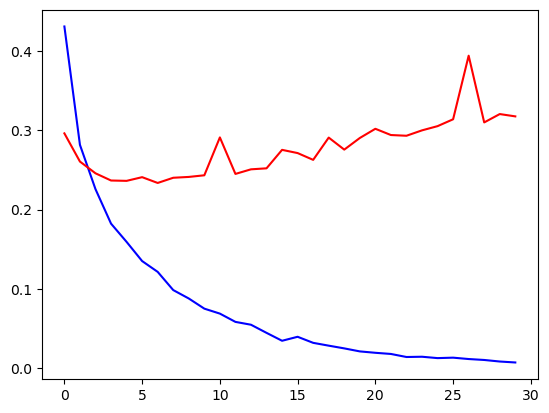

In [6]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.plot(model_result.history['loss'], color='b')
plt.plot(model_result.history['val_loss'], color='r')
plt.show()

### 기학습된 network의 특성추출 부분과 분류기를 붙여서 model 생성

In [1]:
### 기학습된 network의 특성추출 부분과 분류기를 붙여서 model 생성

# 기학습된 network를 모델 안에 포함
# 속도 느려짐: 매 epoch마다 이미지의 특성을 추출하기 때문
# data Augmentation 가능
# Filter update 하지 않음

import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

In [2]:
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Validation data에 대해서는 당연히 증식을 사용하면 안된다.
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              classes=['cats', 'dogs'],
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
# model 생성

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False # 필터 값 update 안함

model = Sequential()

model.add(model_base)

# classifier의 input layer
model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(256,
                activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# 모델 설정
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

model_result = model.fit(train_generator,
                         steps_per_epoch=100,
                         epochs=30,
                         validation_data=validation_generator,
                         validation_steps=50,
                         verbose=1)

Epoch 1/30
100/100 [==============================] - 165s 2s/step - loss: 0.5504 - accuracy: 0.7215 - val_loss: 0.3541 - val_accuracy: 0.8440
Epoch 2/30
100/100 [==============================] - 168s 2s/step - loss: 0.4117 - accuracy: 0.8070 - val_loss: 0.3029 - val_accuracy: 0.8670
Epoch 3/30
100/100 [==============================] - 174s 2s/step - loss: 0.3606 - accuracy: 0.8410 - val_loss: 0.2665 - val_accuracy: 0.8920
Epoch 4/30
100/100 [==============================] - 179s 2s/step - loss: 0.3431 - accuracy: 0.8525 - val_loss: 0.2598 - val_accuracy: 0.9010
Epoch 5/30
100/100 [==============================] - 177s 2s/step - loss: 0.3270 - accuracy: 0.8560 - val_loss: 0.2530 - val_accuracy: 0.9010
Epoch 6/30
100/100 [==============================] - 184s 2s/step - loss: 0.3148 - accuracy: 0.8630 - val_loss: 0.2693 - val_accuracy: 0.8890
Epoch 7/30
100/100 [==============================] - 185s 2s/step - loss: 0.3087 - accuracy: 0.8665 - val_loss: 0.2463 - val_accuracy: 0.9070

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.plot(model_result.history['loss'], color='b')
plt.plot(model_result.history['val_loss'], color='r')
plt.show()

### Fine Tuning

In [ ]:
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Validation data에 대해서는 당연히 증식을 사용하면 안된다.
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              classes=['cats', 'dogs'],
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary')

In [ ]:
# model 생성

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = True

for layer in model_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:    
        layer.trainable = False

model = Sequential()

model.add(model_base)

# classifier의 input layer
model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(256,
                activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# 모델 설정
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()